# May 31st, 2022 (Results so far: GABAN, 512 * 3)

**Motivation**: Make group plots (GABAN) 

Findings:
1. 
2. 
3. 

<br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from numpy.ma import masked_where as mwh
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
fig_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
# HIDE CODE


def quick_show(
    data,
    vmin=0.1,
    vmax=None,
    figsize=None,
    cmap='magma',
    ylabel_fontsize=11.5,
    show: bool = True, ):
    num = max(len(tr['proj-top']) for tr in data.values())
    figsize = figsize if figsize else (13.5, 1.4 * len(data))
    fig, axes = create_figure(
        nrows=len(data),
        ncols=num,
        figsize=figsize,
        tight_layout=False,
        constrained_layout=False,
        reshape=True,
    )
    for i, (lbl, tr) in enumerate(data.items()):
        for j in range(num):
            ax = axes[i, j]
            if j >= len(tr['proj-top']):
                ax.remove()
            else:
                ax.imshow(mwh(tr['top'] == 0, tr['top']), cmap='Greys_r')
                if np.nanmax(tr['proj-top'][j]) > 1:
                    _cmap = get_cluster_cmap(range(len(tr['proj-top']) - 1))
                    _vmax = None
                else:
                    _cmap = cmap
                    _vmax = vmax
                ax.imshow(
                    mwh(tr['proj-top'][j] < vmin, tr['proj-top'][j]),
                    cmap=_cmap, vmin=vmin, vmax=_vmax,
                )
                if j == 0:
                    ax.set_ylabel(lbl, fontsize=ylabel_fontsize)
    remove_ticks(axes)
    if show:
        plt.show()
    else:
        plt.close()
    return fig, axes

    
def mk_looper(kk, bb=None, tasks=None):
    bb = bb if bb else [(0.01, 0.5)]
    tasks = tasks if tasks else ['rest', 'led', 'all']
    return itertools.product(kk, bb, tasks)


def summary(
    nn: int,
    mode: str,
    p: int,
    k_all: Iterable[int],
    kw_prune: dict = None,
    kw_mg1: dict = None,
    kw_mg2: dict = None, ):
    
    mice = Mice(nn)
    props = {
        'mice': mice,
        'mode': mode,
        'perc': f'p{p}-sample',
        'num_k': None,
        'task': None,
        'metric': 'pearson',
        'match_using': 'gam',
        'match_metric': 'euclidean',
        'graph_type': 'real',
        'verbose': False,
    }
    bb = [(0.01, 0.5)]
    if mode == 'ca2':
        bb += [0.5]

    # Load pi
    pi_all = {}
    for num_k, b, task in mk_looper(k_all, bb):
        kwargs = {
            'band_ca' if
            mode == 'ca2'
            else 'band_bo': b,
            'runs_only': True,
            'exclude': True,
            'task': task,
        }
        mice.setup_func_data(**kwargs)
        props['num_k'] = num_k
        props['task'] = task

        gr = Group(**props).fit_group()
        if kw_prune:
            pruned = gr.prune(**kw_prune)
            gr.run_pi = pruned['pi_prune_run']
        if kw_mg1:
            try:
                _ = gr._merge_vis(**kw_mg1)
            except RuntimeError:
                pass
            if kw_mg2:
                try:
                    _ = gr._merge_vis(**kw_mg2)
                except RuntimeError:
                    pass
        else:
            gr.avg()
        pi_all[(mode, num_k, b, task)] = gr.pi

    # Align
    d2p = {}
    for num_k, b, task in mk_looper(k_all, bb):
        pi = pi_all[(mode, num_k, b, task)]
        pi_src = pi_all[(mode, num_k, (0.01, 0.5), 'rest')]
        try:
            gmap = find_best_mappings(pi_src, {0: pi})[0]
            new_ids = list(gmap.values())
        except AssertionError:
            new_ids = range(len(pi))
        lbl = f"{mode.split('-')[0]}-k{num_k}\nb-{b}\ntask-{task}".replace(' ', '')
        d2p[lbl] = gr.trim2d(gr.project_vec(pi[new_ids]))
    
    return pi_all, d2p

## Fig dir

In [3]:
fig_kws = {
    'dpi': 300,
    'transparent': False,
    'bbox_inches': 'tight',
}
fig_dir = pjoin(fig_dir, 'pi_cortex')
os.makedirs(fig_dir, exist_ok=True)

## Prepare (512 * 3)

In [4]:
nn = 512
mice = Mice(nn)

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

vmin = 0.1
vmax = 1.0

kw_prune = {
    'n_resamples': int(7e3),
    'thres': 0.01,
    'ci': 0.95,
}
kw_mg1={'thres': 0.05}
kw_mg2={'thres': 0.1}

## p = 10

In [5]:
p = 10

### CA2

#### 1) Ca2 (true)

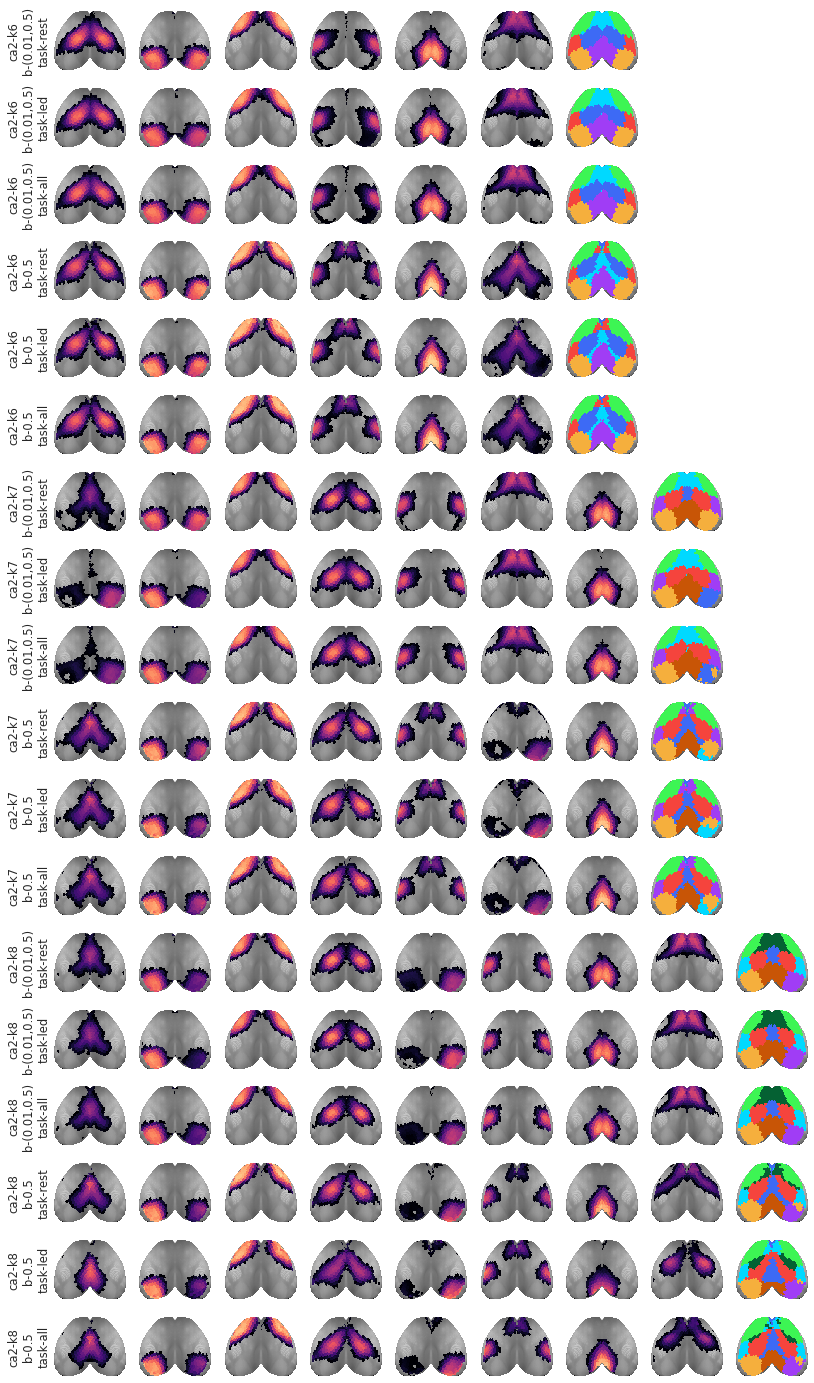

In [6]:
mode = 'ca2'
pi_ca, d2p_ca = summary(
    nn=nn,
    mode=mode,
    p=p,
    k_all=[6, 7, 8],
    kw_prune=None,
    kw_mg1=None,
    kw_mg2=None,
)
fig, _ = quick_show(d2p_ca, vmin=vmin, vmax=vmax)
fig.savefig(pjoin(fig_dir, f"n{nn}-{mode}_p{p}-k[6-8].png"), **fig_kws)

#### 2) Ca2 (prune)

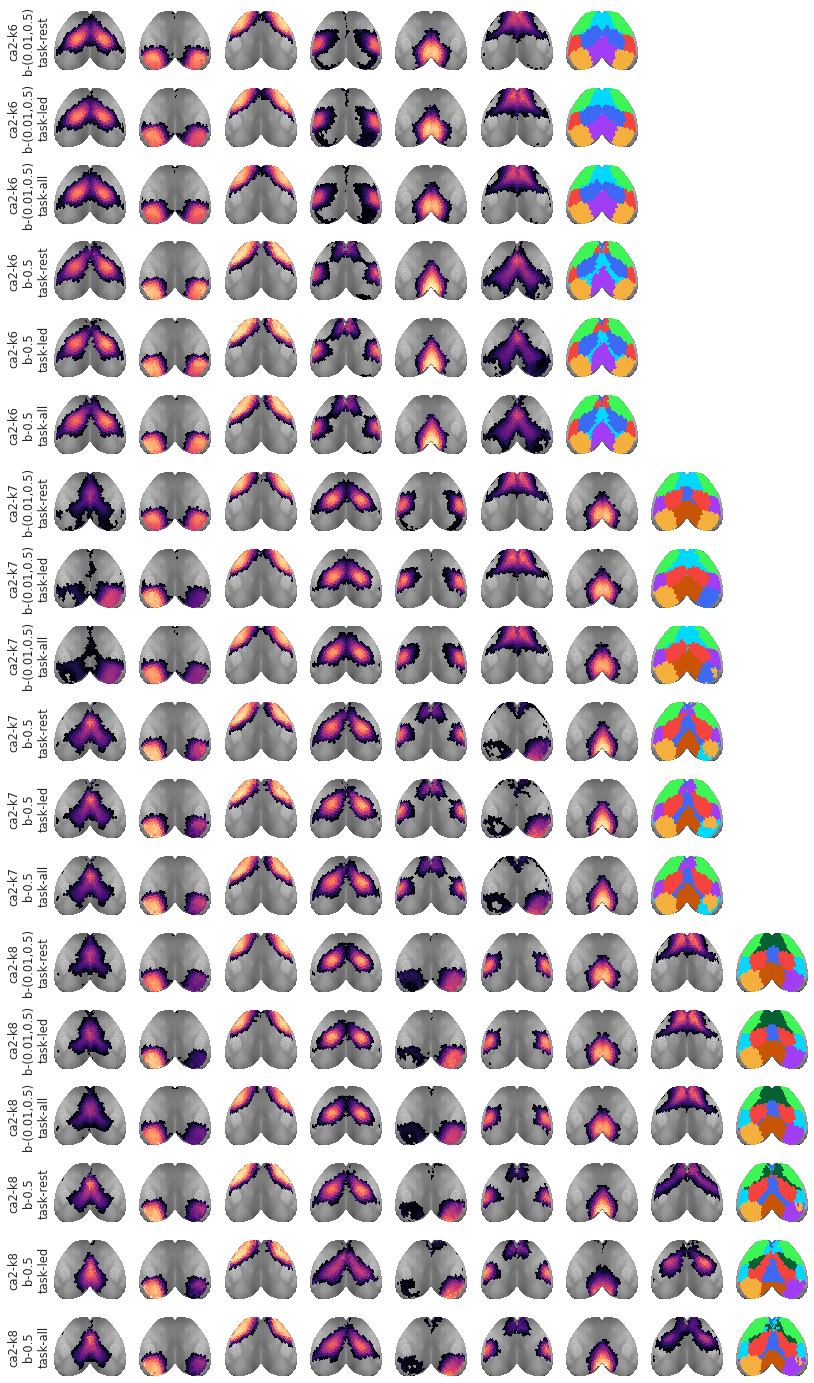

CPU times: user 35 s, sys: 24.1 s, total: 59.1 s
Wall time: 59.6 s


In [7]:
%%time

mode = 'ca2'
pi_ca, d2p_ca = summary(
    nn=nn,
    mode=mode,
    p=p,
    k_all=[6, 7, 8],
    kw_prune=kw_prune,
    kw_mg1=None,
    kw_mg2=None,
)
fig, _ = quick_show(d2p_ca, vmin=vmin, vmax=vmax)
fig.savefig(pjoin(fig_dir, f"n{nn}-{mode}_p{p}-k[6-8]_pr.png"), **fig_kws)

#### 3) Ca2 (prune + merge)

In [8]:
mode = 'ca2'
pi_ca, d2p_ca = summary(
    nn=nn,
    mode=mode,
    p=p,
    k_all=[6, 7, 8],
    kw_prune=kw_prune,
    kw_mg1=kw_mg1,
    kw_mg2=None,
)
fig, _ = quick_show(d2p_ca, vmin=vmin, vmax=vmax)
fig.savefig(pjoin(fig_dir, f"n{nn}-{mode}_p{p}-k[6-8]_pr-mg1.png"), **fig_kws)

### BOLD-Lite

#### 1) Bold (true)

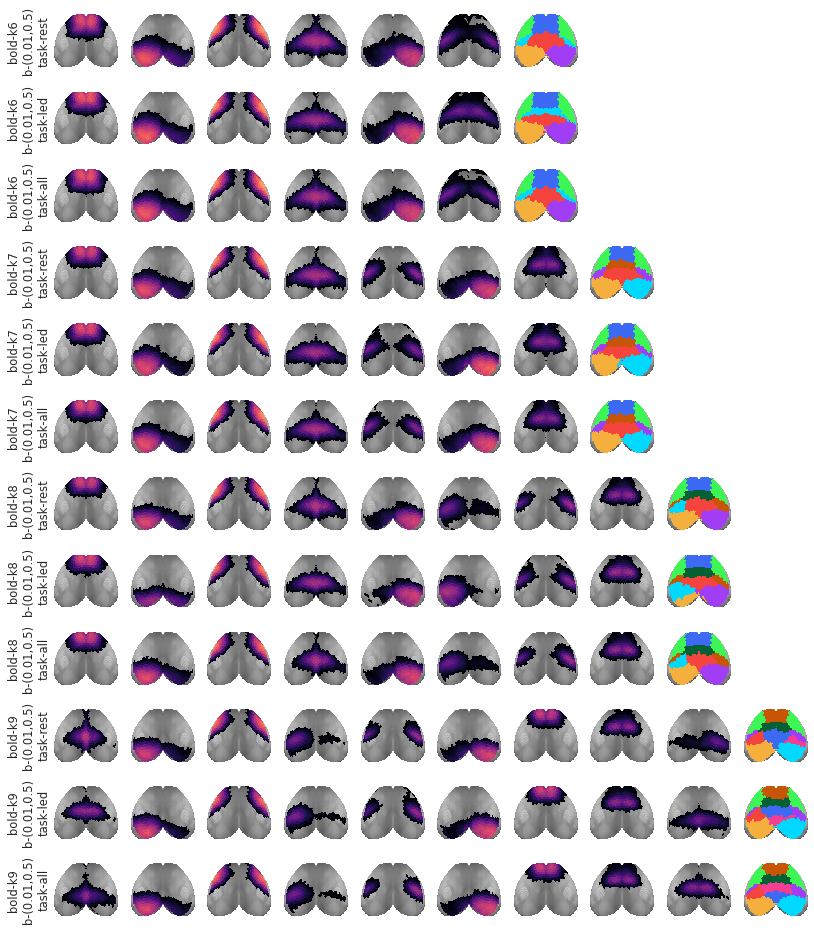

In [9]:
mode = 'bold-lite'
pi_bo, d2p_bo = summary(
    nn=nn,
    mode=mode,
    p=p,
    k_all=range(6, 10),
    kw_prune=None,
    kw_mg1=None,
    kw_mg2=None,
)
fig, _ = quick_show(d2p_bo, vmin=vmin, vmax=vmax)
fig.savefig(pjoin(fig_dir, f"n{nn}-{mode.split('-')[0]}_p{p}-k[6-9].png"), **fig_kws)

#### 2) Bold (prune)

In [10]:
kw_prune['n_resamples'] = int(1e3)

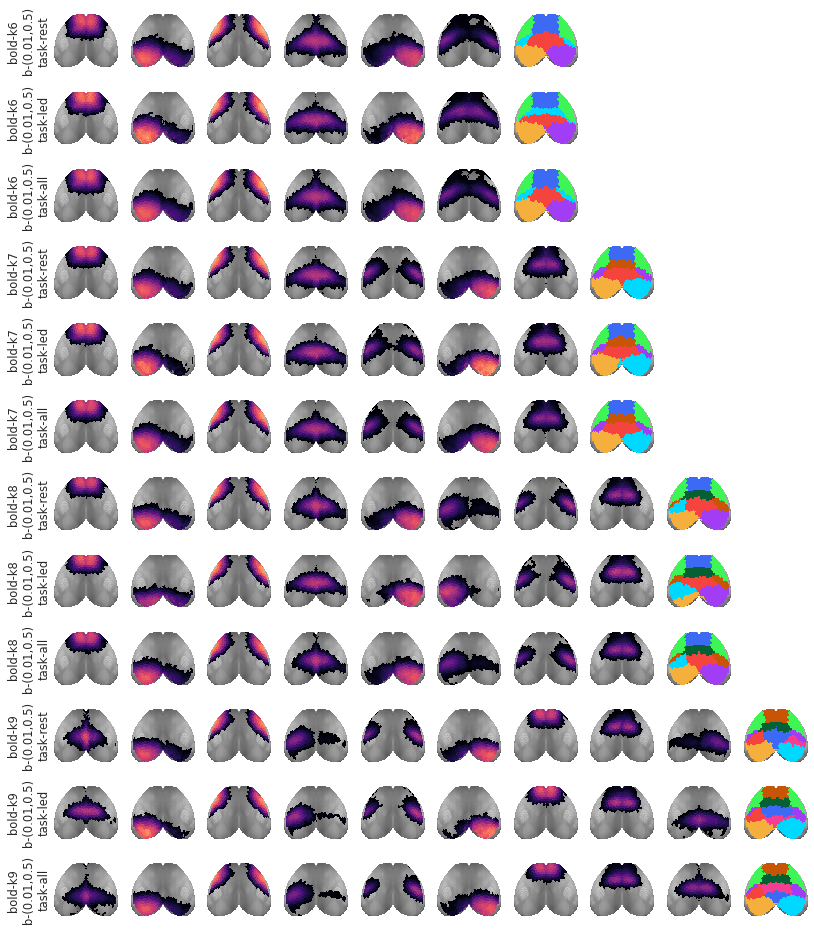

In [11]:
mode = 'bold-lite'
pi_bo, d2p_bo = summary(
    nn=nn,
    mode=mode,
    p=p,
    k_all=range(6, 10),
    kw_prune=kw_prune,
    kw_mg1=None,
    kw_mg2=None,
)
fig, _ = quick_show(d2p_bo, vmin=vmin, vmax=vmax)
fig.savefig(pjoin(fig_dir, f"n{nn}-{mode.split('-')[0]}_p{p}-k[6-9]_pr.png"), **fig_kws)

#### 3) Bold (prune + merge)

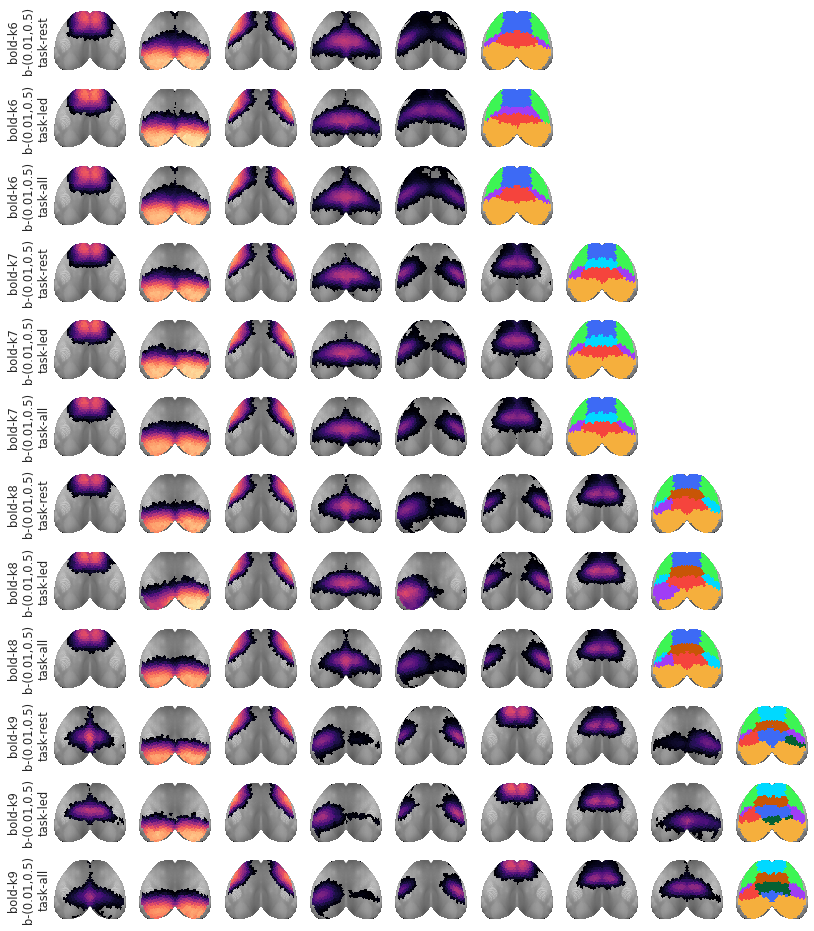

In [12]:
mode = 'bold-lite'
pi_bo, d2p_bo = summary(
    nn=nn,
    mode=mode,
    p=p,
    k_all=range(6, 10),
    kw_prune=kw_prune,
    kw_mg1=kw_mg1,
    kw_mg2=None,
)
fig, _ = quick_show(d2p_bo, vmin=vmin, vmax=vmax)
fig.savefig(pjoin(fig_dir, f"n{nn}-{mode.split('-')[0]}_p{p}-k[6-9]_pr-mg1.png"), **fig_kws)

#### 4) Bold (prune + merge + merge)

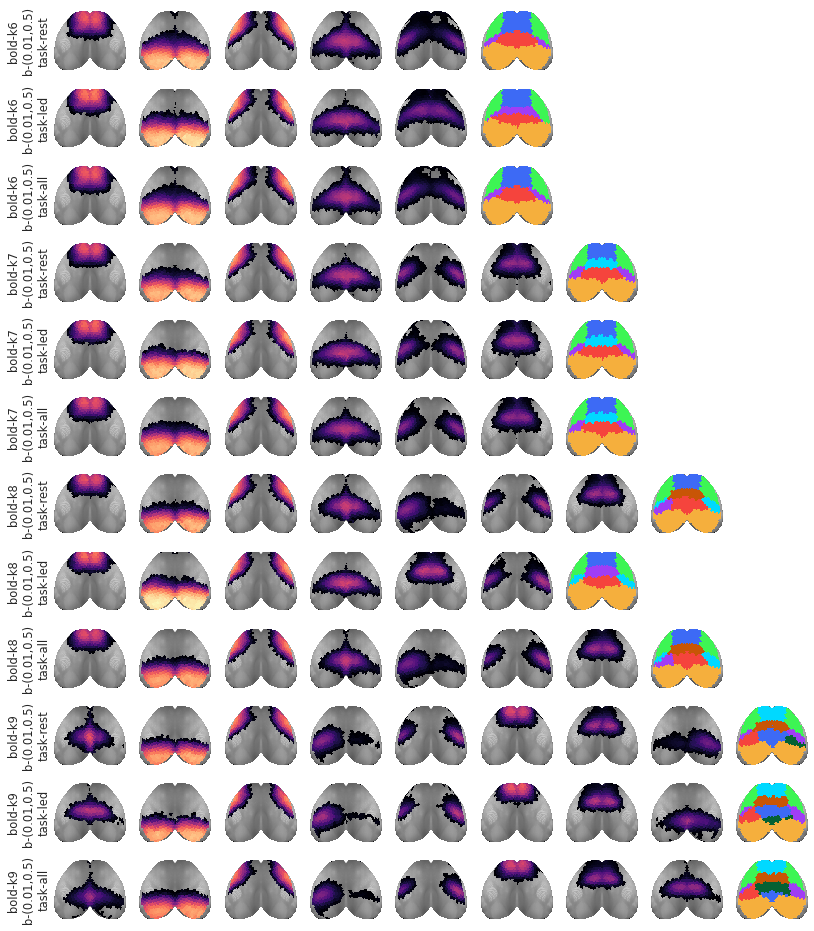

In [13]:
mode = 'bold-lite'
pi_bo, d2p_bo = summary(
    nn=nn,
    mode=mode,
    p=p,
    k_all=range(6, 10),
    kw_prune=kw_prune,
    kw_mg1=kw_mg1,
    kw_mg2=kw_mg2,
)
fig, _ = quick_show(d2p_bo, vmin=vmin, vmax=vmax)
fig.savefig(pjoin(fig_dir, f"n{nn}-{mode.split('-')[0]}_p{p}-k[6-9]_pr-mg2.png"), **fig_kws)

## p = 20

In [14]:
p = 20

### CA2

#### 1) Ca2 (true)

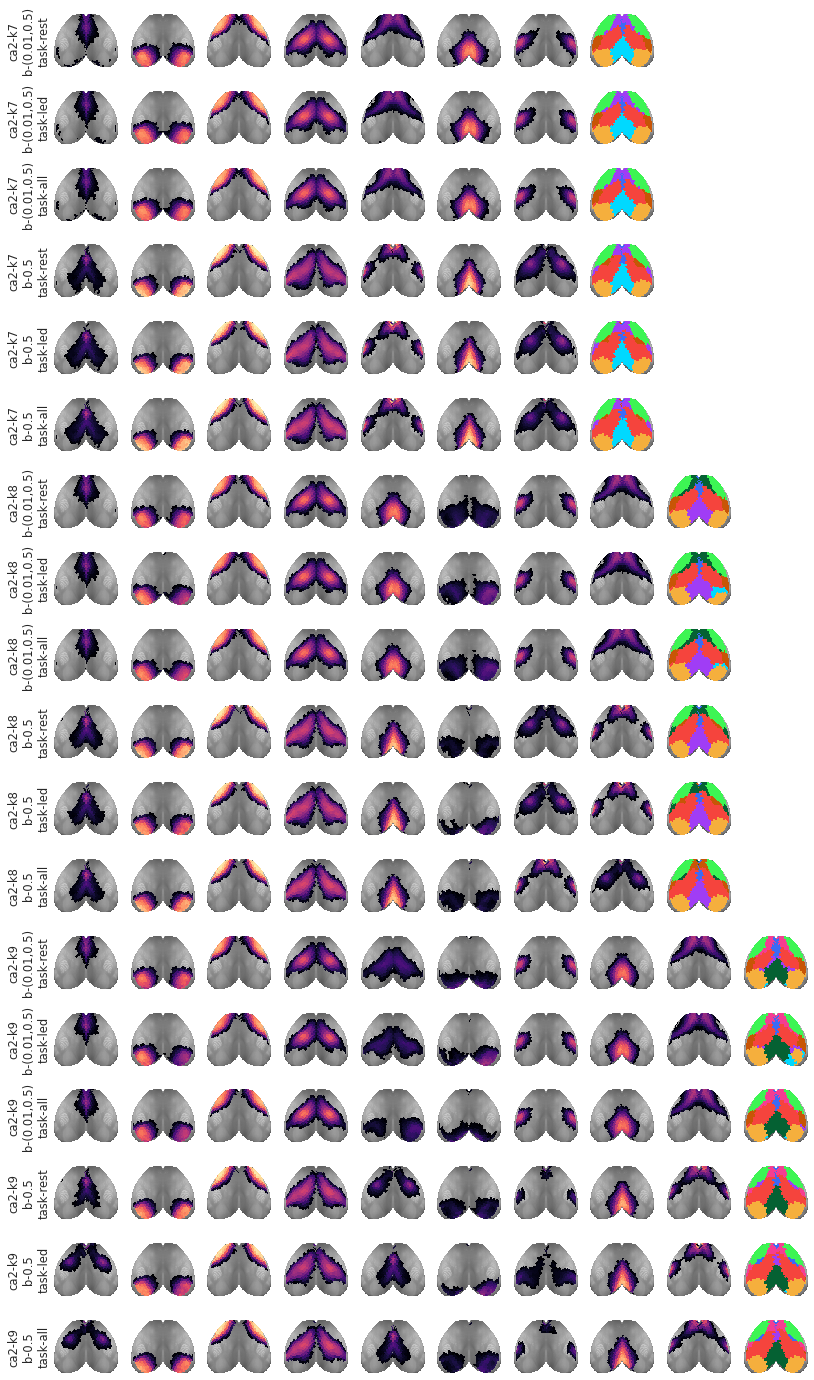

In [15]:
mode = 'ca2'
pi_ca, d2p_ca = summary(
    nn=nn,
    mode=mode,
    p=p,
    k_all=[7, 8, 9],
    kw_prune=None,
    kw_mg1=None,
    kw_mg2=None,
)
fig, _ = quick_show(d2p_ca, vmin=vmin, vmax=vmax)
fig.savefig(pjoin(fig_dir, f"n{nn}-{mode}_p{p}-k[7-9].png"), **fig_kws)

#### 2) Ca2 (prune)

In [16]:
%%time

mode = 'ca2'
pi_ca, d2p_ca = summary(
    nn=nn,
    mode=mode,
    p=p,
    k_all=[7, 8, 9],
    kw_prune=kw_prune,
    kw_mg1=None,
    kw_mg2=None,
)
fig, _ = quick_show(d2p_ca, vmin=vmin, vmax=vmax)
fig.savefig(pjoin(fig_dir, f"n{nn}-{mode}_p{p}-k[7-9]_pr.png"), **fig_kws)

CPU times: user 1min 35s, sys: 3min 4s, total: 4min 39s
Wall time: 5min 29s


#### 3) Ca2 (prune + merge)

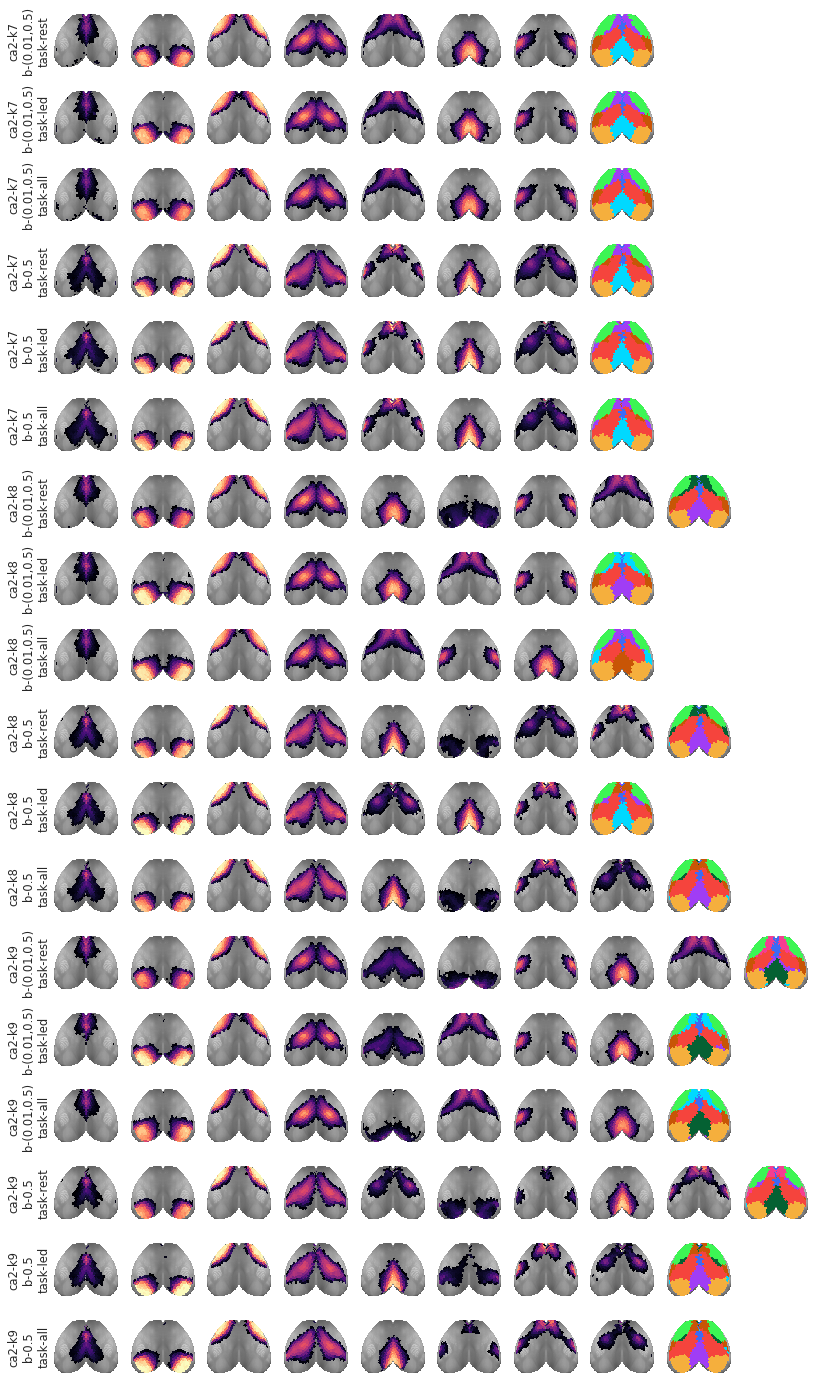

In [17]:
mode = 'ca2'
pi_ca, d2p_ca = summary(
    nn=nn,
    mode=mode,
    p=p,
    k_all=[7, 8, 9],
    kw_prune=kw_prune,
    kw_mg1=kw_mg1,
    kw_mg2=None,
)
fig, _ = quick_show(d2p_ca, vmin=vmin, vmax=vmax)
fig.savefig(pjoin(fig_dir, f"n{nn}-{mode}_p{p}-k[7-9]_pr-mg1.png"), **fig_kws)

### BOLD-Lite

#### 1) Bold (true)

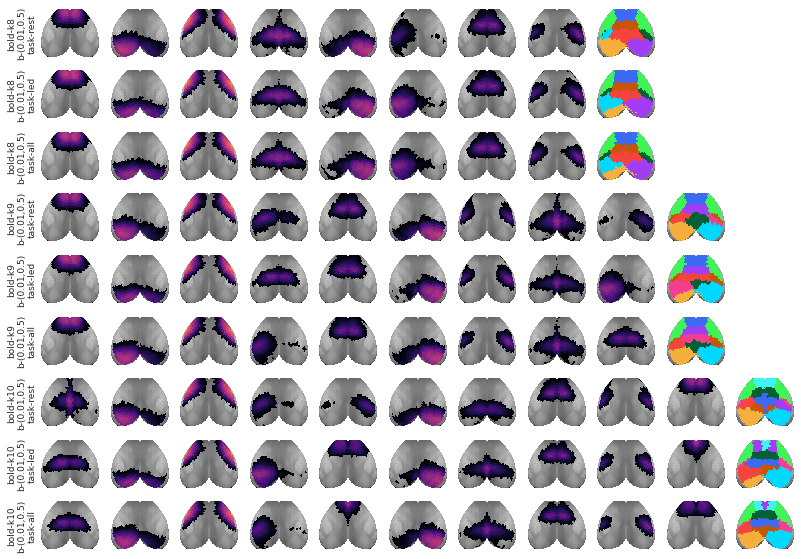

In [23]:
mode = 'bold-lite'
pi_bo, d2p_bo = summary(
    nn=nn,
    mode=mode,
    p=p,
    k_all=[8, 9, 10],
    kw_prune=None,
    kw_mg1=None,
    kw_mg2=None,
)
fig, _ = quick_show(d2p_bo, vmin=vmin, vmax=vmax, figsize=(13.5, 10), ylabel_fontsize=9)
fig.savefig(pjoin(fig_dir, f"n{nn}-{mode.split('-')[0]}_p{p}-k[8-10].png"), **fig_kws)

#### 2) Bold (prune)

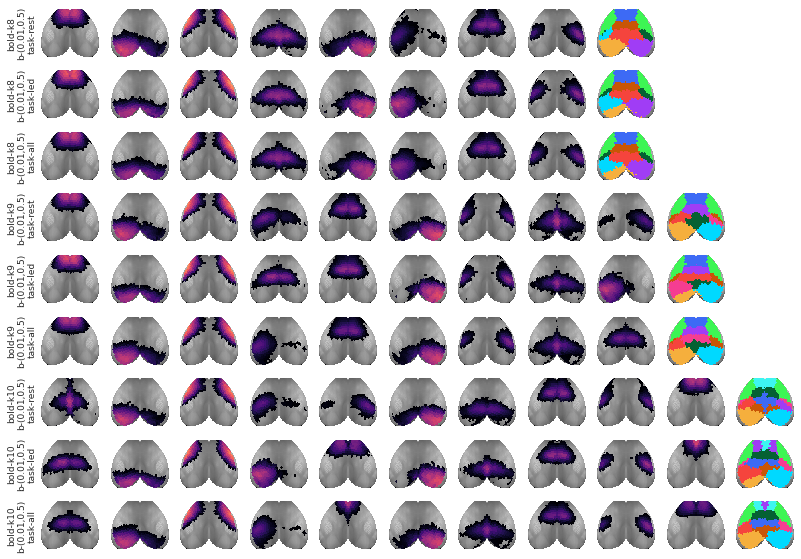

In [28]:
mode = 'bold-lite'
pi_bo, d2p_bo = summary(
    nn=nn,
    mode=mode,
    p=p,
    k_all=[8, 9, 10],
    kw_prune=kw_prune,
    kw_mg1=None,
    kw_mg2=None,
)
fig, _ = quick_show(d2p_bo, vmin=vmin, vmax=vmax, figsize=(13.5, 10), ylabel_fontsize=9)
fig.savefig(pjoin(fig_dir, f"n{nn}-{mode.split('-')[0]}_p{p}-k[8-10]_pr.png"), **fig_kws)

#### 3) Bold (prune + merge)

In [26]:
mode = 'bold-lite'
pi_bo, d2p_bo = summary(
    nn=nn,
    mode=mode,
    p=p,
    k_all=[8, 9, 10],
    kw_prune=kw_prune,
    kw_mg1=kw_mg1,
    kw_mg2=None,
)
fig, _ = quick_show(d2p_bo, vmin=vmin, vmax=vmax, figsize=(13.5, 11), ylabel_fontsize=9)
fig.savefig(pjoin(fig_dir, f"n{nn}-{mode.split('-')[0]}_p{p}-k[8-10]_pr-mg1.png"), **fig_kws)

#### 4) Bold (prune + merge + merge)

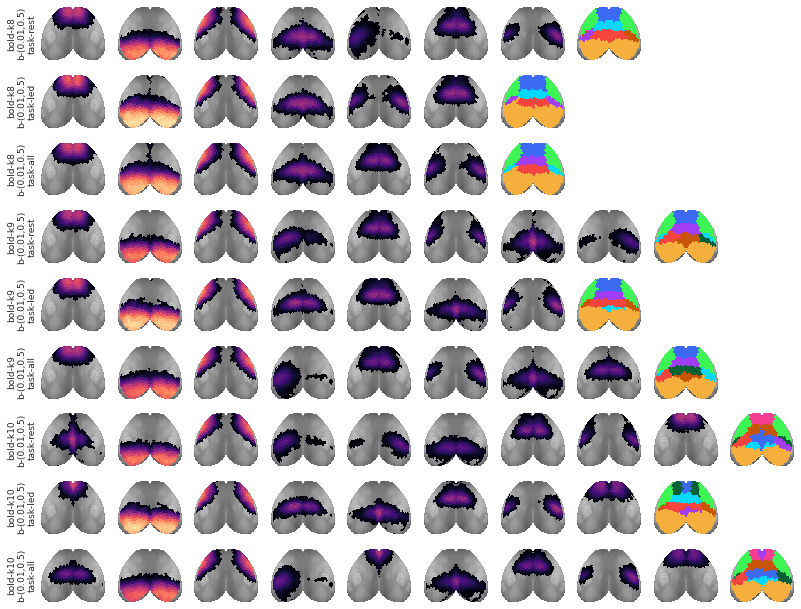

In [27]:
mode = 'bold-lite'
pi_bo, d2p_bo = summary(
    nn=nn,
    mode=mode,
    p=p,
    k_all=[8, 9, 10],
    kw_prune=kw_prune,
    kw_mg1=kw_mg1,
    kw_mg2=kw_mg2,
)
fig, _ = quick_show(d2p_bo, vmin=vmin, vmax=vmax, figsize=(13.5, 11), ylabel_fontsize=9)
fig.savefig(pjoin(fig_dir, f"n{nn}-{mode.split('-')[0]}_p{p}-k[8-10]_pr-mg2.png"), **fig_kws)